# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».   

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных**  
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.  
Известно: 
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**План проекта:**
1. Изучим данные. Сформулируем задачу.
2. Разделим выборку на обучающую, валидационную и тестовую.
3. Выберем несколько моделей и исследуем качество их предсказания в режиме default-настройки гиперпараметров.
4. Выберем модель, которая показала наилучший результат. Попробуем улучшить его путем настройки гиперпараметров.
5. Проверим модель на тестовой выборке.
6. Проверим модель на адекватность

## Импорт библиотек и подготовка окружения

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Откройте и изучите файл

Сохраним данные в переменную `df`

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

# Выведем на экран первые 5 строк датафрейма
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В данных содержится 3214 строк.  
Все признаки - числовые.  
Пропуски отсутствуют.  
В данных имеются 5 признаков: 
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  


Целевой признак, который будем предсказывать - `is_ultra`  
Таким образом, мы будем решать задачу бинарной классификации.  
Метрика, которая будет выбрана для оценки модели - Accuracy.

### Небольшая предобработка

Сделаем небольшую предобработку данных. Количество звонков и сообщений приведем к типу `int`

In [4]:
columns = ['calls', 'messages']

for col in columns:
    df[col] = df[col].astype('int')
    
# Проверим результат преобразования
df[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 2 columns):
calls       3214 non-null int64
messages    3214 non-null int64
dtypes: int64(2)
memory usage: 50.3 KB


### Посмотрим на описание данных

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


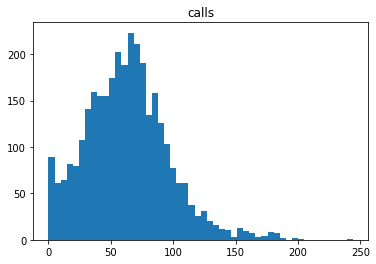

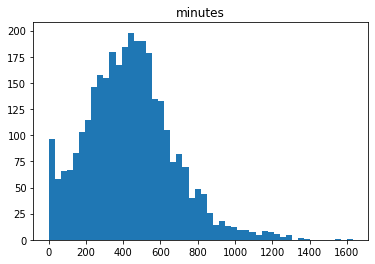

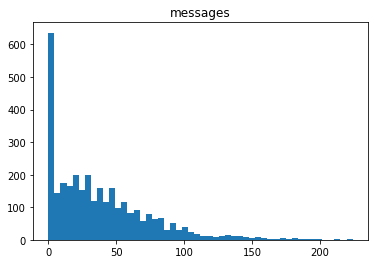

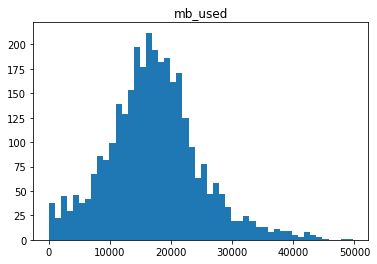

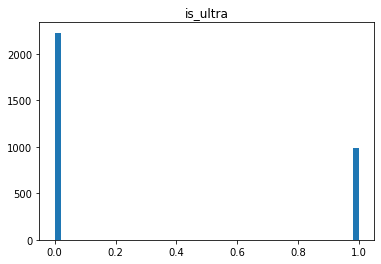

In [6]:
for col in df.columns:
    plt.hist(df[col], bins=50)
    plt.title(col)
    plt.show()

С данными все в порядке. Можно приступать к следующему этапу - разбиению выборки.

## Разбейте данные на выборки

Сохраним матрицу признаков в таблицу `X`, а матрицу ответов в таблицу `y`

In [7]:
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']

print(X.shape, y.shape)

(3214, 4) (3214,)


Разделим выборки на обучающую, валидационную и тестовую в соотнощении 60%, 20%, 20% соответственно.

Первым шагом отделим 20% тестовой выборки.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [9]:
for data in [X_train, y_train, X_test, y_test]:
    print(data.shape)

(2571, 4)
(2571,)
(643, 4)
(643,)


Теперь разделим тренировочную выборку и валидационную выборки. Валидационная выборка относится к тренировочной в соотношении 1 к 3-м (в соответсвии с изначальным делением 60%, 20%, 20%)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5)

In [11]:
for data in [X_train, y_train, X_val, y_val]:
    print(data.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)


## Исследуйте модели

На данном этапе исследуем 3 модели классификации:
- DecisionTreeClassifier
- RandomForestClassifier
- LinearRegression

### Проверим модели с настройками default

Для начала, посмотрим, какой результат даст каждая из моделей без подкрутки гиперпараметров.

In [12]:
for name, model in {'DecisionTreeClassifier': DecisionTreeClassifier, 
                    'LogisticRegression': LogisticRegression, 
                    'RandomForestClassifier': RandomForestClassifier}.items():
    m = model(random_state=23)
    n = name
    m.fit(X_train, y_train)
    print(f'Accuracy модели {n} на обучающей выборке: {m.score(X_train, y_train)}')
    print(f'Accuracy модели {n} на валидационной выборке {m.score(X_val, y_val)}')
    print('-----')

Accuracy модели DecisionTreeClassifier на обучающей выборке: 1.0
Accuracy модели DecisionTreeClassifier на валидационной выборке 0.7262830482115086
-----
Accuracy модели LogisticRegression на обучающей выборке: 0.7059128630705395
Accuracy модели LogisticRegression на валидационной выборке 0.6889580093312597
-----
Accuracy модели RandomForestClassifier на обучающей выборке: 0.9802904564315352
Accuracy модели RandomForestClassifier на валидационной выборке 0.8055987558320373
-----


**DecisionTreeClassifier** - переобучилась, в результате чего получила 100% точность предказания на обучающей выборке, и всего 72% на валидационной.  
**LogisticRegression** - недообучилась, в результате чего показала одинаково низкий результат как на обучающей, так и на валидационной выборках.   
**RandomForestClassifier** - показала лучший результат среди трех на валидационной выборке - 80,6%   

Возмьмем лучшую из трех моделей с точки зрения показателя accuracy и посмотрим, получится ли улучшить данный результат.

### Подберем значения гиперпараметров для выбранной модели

Переберем комбинации следющих значений гиперпараметров:  
- `n_estimators` = range(50, 501, 50)
- `criterion` = ['gini', 'entropy']
- `max_features` = ['sqrt', 'log2']
- `max_depth` = [7, 10, 13]

Сохраним модель с наилучшей подобранной комбинацией гиперпараметров в переменной `RF_best`

In [13]:
score_best = 0
RF_best = None
best_params = {}

n_estimators = range(50, 501, 50)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2']
max_depth = [7, 10, 13]


for n_est in tqdm(n_estimators, desc="Идет подбор параметров...", colour='green'):
    for crit in criterion:
        for mx_f in max_features:
            for mx_depth in max_depth:
                RF = RandomForestClassifier(n_estimators=n_est, 
                                            criterion=crit, 
                                            max_features=mx_f,
                                            max_depth=mx_depth,
                                            random_state=23)
                RF.fit(X_train, y_train)
                score = RF.score(X_val, y_val)
            
                # Если accuracy выше, чем у предыдущих моделей, сохраним модель и значение ее параметров
                if score > score_best:
                    score_best=score
                    RF_best = RF
                    best_params['n_estimators'] = n_est
                    best_params['criterion'] = crit
                    best_params['max_features'] = mx_f
                    best_params['max_depth'] = mx_depth
                
                
print(f'Наилучший accuracy на валидационной выборке: {score_best}')
display('Значения гиперпараметров:', best_params)

Идет подбор параметров...: 100%|██████████| 10/10 [02:31<00:00, 15.14s/it]

Наилучший accuracy на валидационной выборке: 0.8102643856920684


'Значения гиперпараметров:'

{'n_estimators': 100,
 'criterion': 'gini',
 'max_features': 'sqrt',
 'max_depth': 10}

Нам удалось незначительно повысить accuracy модели c 0.806 до 0.81.  

Можно также посмотреть, важность признаков для нашей модели.

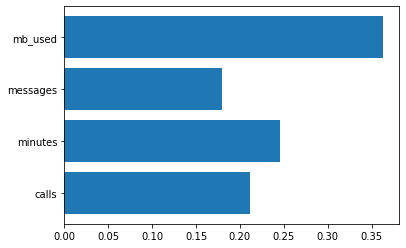

In [14]:
plt.barh(X.columns, RF_best.feature_importances_);

Наиболее важным с точки зрения предсказания тарифа пользователя оказался показатель использованного интернет-траффика.

Следующим шагом проверим модель на тестовой выборке.

## Проверьте модель на тестовой выборке

Проверим accuracy модели `RF_best` на тестовой выборке:

In [15]:
print(f'Accuracy модели на тестовой выборке: {RF_best.score(X_test, y_test)}')

Accuracy модели на тестовой выборке: 0.7947122861586314


## (бонус) Проверьте модели на адекватность

Посмотрим на соотношение категорий в нашей целевой переменной.

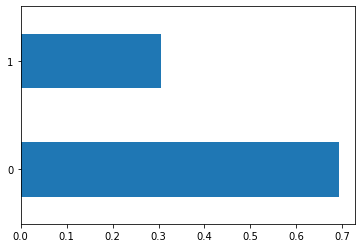

In [16]:
df['is_ultra'].value_counts(normalize=True).plot.barh();

Категории "0" представлена в большем количестве. Значит, если мы возьмем модель, которая каждый раз будет предсказывать, что клиент пользуется тарифом Smart, то мы будем правы чаще, чем если будем каждый раз предсказывать тариф Ultra.

In [17]:
print(f"""Модель, которая каждый раз предсказывает, что клиент пользуется тарифом Smart, будет права в {round((1-df['is_ultra'].mean())*100, 1)}% случаев""")

Модель, которая каждый раз предсказывает, что клиент пользуется тарифом Smart, будет права в 69.4% случаев


Accuracy нашей модели на тестовой выборке составляет 79,5%, и является выше данного показателя.

## Резюме

Целью данной работы было обучить модель предсказывать какой тариф подойдет пользователю, исходя из количества звонков, сообщений, минут разговоров и израсходованного пользователем интернет траффика.  

В ходе работы:  
1. Данные были поделены на 3 выборки:
- Обучающая (60%)
- Валидационная (20%)
- Тестовая (20%)
2. Были исследованы 3 модели: DecisionTreeClassifier, LogisticRegression, RandomForestClassifier.  
Каждую из них мы обучили с default-настройками гиперпараметров и проверили результат предсказания на валидационной выборке. Таким образом были получены следующие результаты:  

Модель | Accuracy на обучающей выборке | Accuracy на валидационной выборке
------ | ------------------------------ | ------------------------
DecisionTreeClassifier | 100% | 72%  
LogisticRegression | 70,6% | 68,9% 
RandomForestClassifier | 98% | 80,6%

- DecisionTreeClassifier - переобучилась, в результате чего получила 100% точность предказания на обучающей выборке, и всего 72% на валидационной.
- LogisticRegression - недообучилась, в результате чего показала одинаково низкий результат как на тестовой, так и на валидационной выборках.
- RandomForestClassifier - показала лучший результат среди трех на валидационной выборке - 80,6%

3. Выл осуществлен подбор гиперпараметров для модели, которая показала себя наилучшим образом с default-настройками (Random Forest).  
Мы перебрали комбинации следующих гиперпараметров:  
- `n_estimators` = range(50, 501, 50)
- `criterion` = ['gini', 'entropy']
- `max_features` = ['sqrt', 'log2']
- `max_depth` = [7, 10, 13]  
 
Наилучшая комбинация гиперпараметров из рассмотренных выше получилась:  
- `n_estimators` = 100
- `criterion` = 'gini'
- `max_features` = 'sqrt',
- `max_depth` = 10

Метрикой было выбрано Accuracy.  
Accuracy нашей модели на валидационной выборке составило 81%, в то время как для тестовой выборки результат составил 79,47%.